# Autoenkoder na MNIST

### Sprawdzenie dostępności karty graficznej do obliczeń 

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Wczytanie MNIST

In [32]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

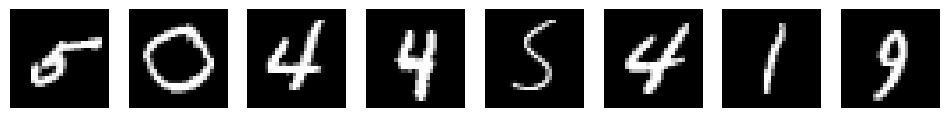

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.show()

## Definicja Autoenkodera

In [6]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Trening

In [7]:
from torch import nn, optim

model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in train_loader:
        # Spłaszczenie danych 
        images = images.view(-1, 28*28).to(device)
        
        outputs = model(images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")

Epoch [1/10], Loss: 0.059248
Epoch [2/10], Loss: 0.040400
Epoch [3/10], Loss: 0.033414
Epoch [4/10], Loss: 0.029075
Epoch [5/10], Loss: 0.027171
Epoch [6/10], Loss: 0.025489
Epoch [7/10], Loss: 0.024419
Epoch [8/10], Loss: 0.023706
Epoch [9/10], Loss: 0.023188
Epoch [10/10], Loss: 0.022764


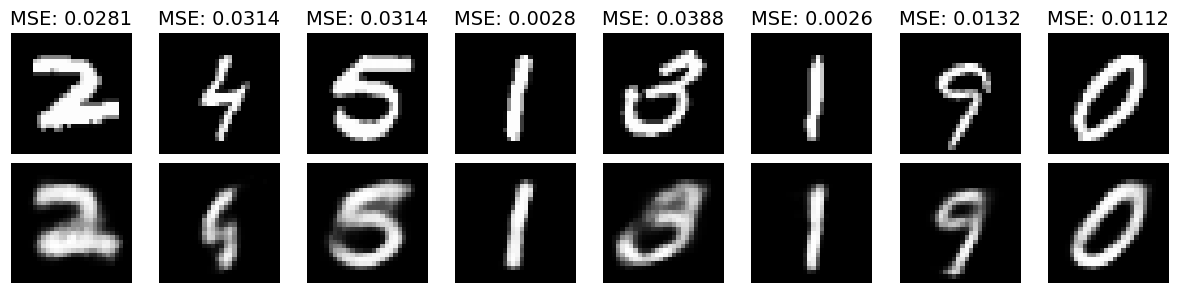

In [47]:
import random
import matplotlib.pyplot as plt
import torch

num_images = 8

indices = random.sample(range(len(test_dataset)), num_images)
images = torch.stack([test_dataset[i][0] for i in indices]).to(device)

model.eval()
with torch.no_grad():
    images_flat = images.view(-1, 28*28)
    reconstructed = model(images_flat)

images = images.view(-1, 28, 28).cpu().numpy()
reconstructed = reconstructed.view(-1, 28, 28).cpu().numpy()

fig, axes = plt.subplots(2, num_images, figsize=(12, 3))
for i in range(num_images):
    mse = ((images[i] - reconstructed[i]) ** 2).mean()
    
    axes[0, i].imshow(images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"MSE: {mse:.4f}", fontsize=14)
    
    axes[1, i].imshow(reconstructed[i], cmap="gray")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


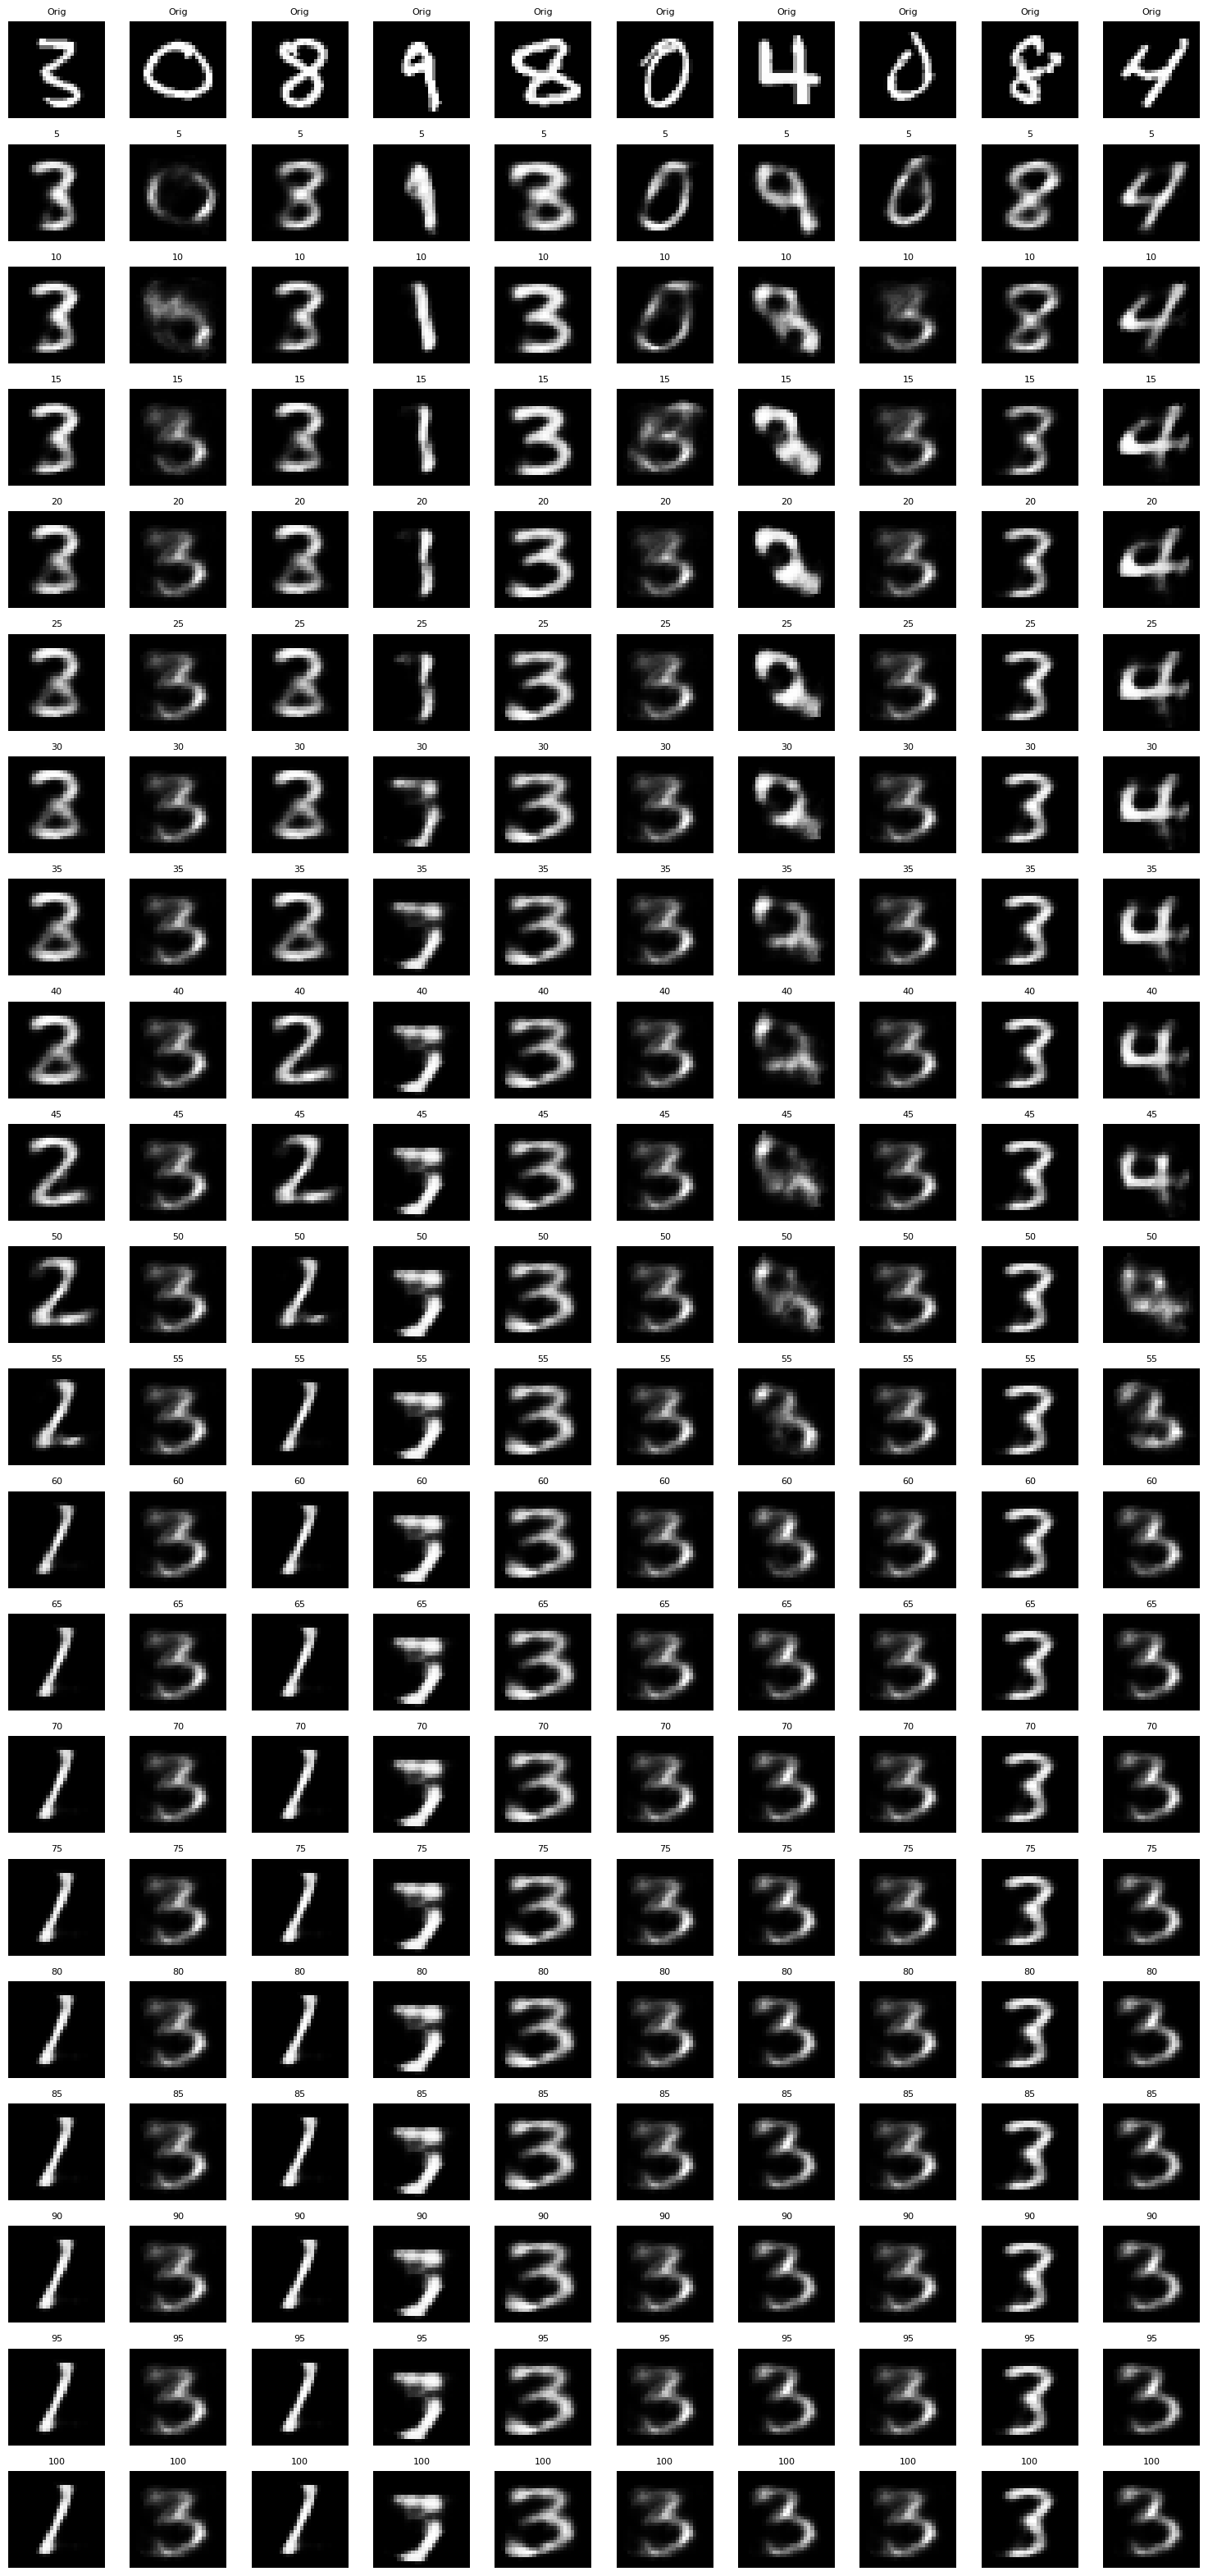

In [ ]:
# Wielokrotne zastosowanie autoenkodera na tych samych obrazach (nie wspomniane w pracy magisterskiej)
import torch
import matplotlib.pyplot as plt
import random

model.eval()
with torch.no_grad():
    num_images = 10
    indices = random.sample(range(len(test_dataset)), num_images)
    original_images = torch.stack([test_dataset[i][0] for i in indices]).to(device)
    images = original_images.clone()  

    num_iterations = 100    # iteracje
    display_every = 5       # co która iteracja wyświetlana
    num_display = num_iterations // display_every

    fig, axes = plt.subplots(num_display+1, num_images, figsize=(num_images*1.5, (num_display+1)*1.5))

    for i in range(num_images):
        axes[0, i].imshow(original_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Orig', fontsize=8)

    for iteration in range(1, num_iterations+1):
        images = model(images.view(-1, 28*28)).view(-1, 28, 28)

        if iteration % display_every == 0:
            row = iteration // display_every
            for i in range(num_images):
                axes[row, i].imshow(images[i].cpu().squeeze(), cmap='gray')
                axes[row, i].axis('off')
                axes[row, i].set_title(f'{iteration}', fontsize=8)

    plt.tight_layout()
    plt.show()

